In [1]:
import pandas as pd
import numpy as np
import pickle
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
from glob import glob
from collections import defaultdict
import scipy
from sklearn.metrics import roc_auc_score

import matplotlib

matplotlib.rcParams.update({'font.size': 20})

#palette:#E69F00,#56B4E9",#0072B2,#D55E00,#CC79A7,#009E73,#F0E442

model_colors = {'DNABERT':"#D55E00",'DNABERT-3UTR':"#ffac6a", 
                '13-mer':"#CC79A7",
                'PhyloP-241way':"#ffd373",
                'PhyloP-100way':"#e69f00",
                'StateSpace':"#0072B2", 'StateSpace-SA':"#59c3ff", 
                'NTv2-250M':"#009E73", 'NTv2-250M-3UTR':"#00dea2"}

In [2]:
data_dir = '/lustre/groups/epigenereg01/workspace/projects/vale/mlm/motif_analysis/'

In [3]:
test_df = pd.read_csv(data_dir + 'test.csv').set_index('seq_name').squeeze()

In [4]:
motif_len = 5 #5 or 6

In [5]:
table_motifs = pd.read_excel(data_dir + 'dominguez_2018/1-s2.0-S1097276518303514-mmc4.xlsx',
             sheet_name = motif_len-4, skiprows=1)

selected_motifs = []

for col_idx in range(0,len(table_motifs.columns),2):
    motif = table_motifs.iloc[:,col_idx:col_idx+1]
    stepwise_r = table_motifs.iloc[:,col_idx+1:col_idx+2]
    selected_motifs.extend(motif[(stepwise_r>0.1).values].values.tolist())

selected_motifs = np.unique(np.array(selected_motifs).flatten())

In [6]:
len(selected_motifs)

153

In [7]:
eclip_pos_intervals = pd.read_pickle(data_dir + '../eCLIP/eCLIP_intervals_3UTR.df')

In [8]:
pred_dir = '/lustre/groups/epigenereg01/workspace/projects/vale/mlm/human_3utr/probs/'

models = {'StateSpace':'stspace/',
          'StateSpace-SA':'stspace-spaw/',
          'DNABERT': 'dnabert/', 
          'DNABERT-3UTR': 'dnabert-3utr/', 
          '13-mer':'K-mer/13_mer/',
          'NTv2-250M': 'ntrans-v2-250m/',
          'NTv2-250M-3UTR': 'ntrans-v2-250m-3utr/',
          'PhyloP-100way': 'PhyloP100/' ,
          'PhyloP-241way': 'PhyloP241/' ,
         }

In [9]:
#models = { 'Species-agnostic':'../species_agnostic/probas.pickle','Species-aware':'../species_aware/probas.pickle', 
#          'DNABERT': '../dnabert/default/*.pickle', '13-mer':'../K-mer/13_mer.pickle',
#          'PhyloP-100way': '../../PhyloP/PhyloP100_3UTR.pickle' ,'PhyloP-241way': '../../PhyloP/PhyloP241_3UTR.pickle', 'NT-MS-v2-500M': 'ntrans/NT-MS-v2-500M/*.pickle'}

In [10]:
mapping = {'A':0,'C':1,'G':2,'T':3}

In [11]:
def get_model(glob_path):
    res = {}
    for probas_file in glob(glob_path):
        #print(probas_file)
        with open(probas_file, 'rb') as f:
            fold_res = pickle.load(f)
            fold_res = {seq_name:{'probs':prob,'seq':seq} for seq_name,prob,seq in zip(fold_res['seq_names'],fold_res['probs'],fold_res['seqs'])}
            res.update(fold_res)
        #    if len(model_probas)==2:
        #        res.update({model_probas[0]:model_probas[1]})
        #    else:
        #        res.update(dict(model_probas))
    return res

In [12]:
res = {}

for model, model_path in models.items():
    res[model] = get_model(pred_dir + '/' + model_path + '/predictions*.pickle')
    print(f'{model} loaded, {len(res[model])} sequences')

StateSpace loaded, 18134 sequences
StateSpace-SA loaded, 18134 sequences
DNABERT loaded, 18134 sequences
DNABERT-3UTR loaded, 18134 sequences
13-mer loaded, 18134 sequences
NTv2-250M loaded, 18134 sequences
NTv2-250M-3UTR loaded, 18134 sequences
PhyloP-100way loaded, 18134 sequences
PhyloP-241way loaded, 18134 sequences


In [13]:
motifs_df = []

for seq_name,seq in tqdm(test_df.items(), total=len(test_df)):
    for motif_start in range(0,len(seq)-motif_len):
        motif_end = motif_start+motif_len
        motif = seq[motif_start:motif_end]
        motif_mapping = [list(range(motif_len)),list(map(lambda x:mapping[x],motif))]
        for model in models:
            if seq_name in res[model]:
                assert res[model][seq_name]['seq'][motif_start:motif_end] == motif
                if not 'PhyloP' in model:
                    avg_target_prob = np.mean(res[model][seq_name]['probs'][motif_start:motif_end][motif_mapping[0], motif_mapping[1]])
                else:
                    avg_target_prob = np.mean(res[model][seq_name]['probs'][motif_start:motif_end])
                motifs_df.append((model,seq_name,motif_start,motif,avg_target_prob))

100%|██████████| 4534/4534 [10:13<00:00,  7.40it/s]


In [14]:
motifs_df = pd.DataFrame(motifs_df,columns = ['model','seq_name','motif_start','motif','avg_target_prob'])

In [15]:
R = 2500 #conservation distance

In [16]:
conservation_csv = data_dir + 'conservation_k5_new.csv.gz'

conservation_df = pd.read_csv(conservation_csv)

conservation_df['mobility'] = conservation_df[f'Nmatches_{R}'] - conservation_df.Nmatches_0

In [17]:
motifs_df = motifs_df.merge(conservation_df, how='left')

In [18]:
motifs_df['functional'] = (motifs_df.motif.isin(selected_motifs))&(motifs_df.is_eCLIP)

In [45]:
mobility_pct = 95

In [46]:
motifs_df['valid_mobility'] = True
if mobility_pct>0:
    motifs_df.loc[motifs_df.L_nearest<2*R,'valid_mobility'] = False

In [47]:
((motifs_df.functional)&(motifs_df.valid_mobility)).sum()

551943

In [48]:
((~motifs_df.functional)&(motifs_df.valid_mobility)).sum()

13996773

In [49]:
mobility_thr = np.nanpercentile(motifs_df[(motifs_df.functional)&(motifs_df.valid_mobility)].mobility, mobility_pct)

In [50]:
mobility_thr

147.0

In [51]:
#models = ('DNABERT','DNABERT-3UTR', 'NTv2-250M','NTv2-250M-3UTR', 
#          'StateSpace', 'StateSpace-SA','13-mer', 'PhyloP-100way', 'PhyloP-241way', )

models = ('DNABERT','DNABERT-3UTR', 'NTv2-250M','NTv2-250M-3UTR', 
          'StateSpace', 'StateSpace-SA', 'PhyloP-100way', 'PhyloP-241way', )

In [52]:
odds_ratios = []

for model in models:

    df = motifs_df[(motifs_df.model==model)&(motifs_df.valid_mobility)]
    
    model_pct_thr_top = np.nanpercentile(df.avg_target_prob,90)
    N_nonfunctional_top = ((df.avg_target_prob>model_pct_thr_top)&(~df.functional)).sum()

    model_pct_thr_bottom = np.nanpercentile(df.avg_target_prob,10)
    N_nonfunctional_bottom = ((df.avg_target_prob<model_pct_thr_bottom)&(~df.functional)).sum()

    if mobility_pct<50 and mobility_pct>0:
        print(f'selecting motifs with mobility BELOW {mobility_pct}pct')
        N_functional_mobile_top = ((df.avg_target_prob>model_pct_thr_top)&(df.functional)&(df.mobility<=mobility_thr)).sum()
        N_functional_mobile_bottom = ((df.avg_target_prob<model_pct_thr_bottom)&(df.functional)&(df.mobility<=mobility_thr)).sum()
    else:
        print(f'selecting motifs with mobility ABOVE {mobility_pct}pct')
        N_functional_mobile_top = ((df.avg_target_prob>model_pct_thr_top)&(df.functional)&(df.mobility>=mobility_thr)).sum()
        N_functional_mobile_bottom = ((df.avg_target_prob<model_pct_thr_bottom)&(df.functional)&(df.mobility>=mobility_thr)).sum()
    
    #N_strong_mobile_motifs = ((selected_motifs_df.mobility>mobility_thr)&(selected_motifs_df.model==model)).sum()
    #strong_mobile_motifs_top = (selected_motifs_df[(selected_motifs_df.mobility>mobility_thr)&(selected_motifs_df.model==model)].avg_target_prob>model_pct_thr_top).sum()

    contig_table = [[N_functional_mobile_top,N_nonfunctional_top],[N_functional_mobile_bottom,N_nonfunctional_bottom]]
    
    fisher_test = scipy.stats.fisher_exact(contig_table)
    
    OR = fisher_test.statistic
    CI_95_high = np.exp(np.log(OR)+1.96*np.sqrt((1/np.array(contig_table)).sum()))
    CI_95_low = np.exp(np.log(OR)-1.96*np.sqrt((1/np.array(contig_table)).sum()))

    auc = roc_auc_score(df.functional[~df.avg_target_prob.isna()],df.avg_target_prob[~df.avg_target_prob.isna()])
    
    print(model,contig_table, fisher_test, auc)
    
    odds_ratios.append((model, OR, CI_95_low, CI_95_high, fisher_test.pvalue, auc))

selecting motifs with mobility ABOVE 95pct
DNABERT [[198, 158700], [188, 153091]] SignificanceResult(statistic=1.015968105216587, pvalue=0.878714814243851) 0.4632432595881117
selecting motifs with mobility ABOVE 95pct
DNABERT-3UTR [[371, 155525], [175, 153570]] SignificanceResult(statistic=2.0933509082141133, pvalue=9.705656688918699e-17) 0.4861633634163444
selecting motifs with mobility ABOVE 95pct
NTv2-250M [[162, 159401], [408, 151906]] SignificanceResult(statistic=0.3783892048798867, pvalue=3.3328793018844395e-28) 0.43962098873729155
selecting motifs with mobility ABOVE 95pct
NTv2-250M-3UTR [[333, 155284], [266, 153258]] SignificanceResult(statistic=1.2355463469988435, pvalue=0.011159068534004123) 0.4935013985733297
selecting motifs with mobility ABOVE 95pct
StateSpace [[288, 156454], [168, 152950]] SignificanceResult(statistic=1.6758919554629477, pvalue=7.875626353979948e-08) 0.48158266303464836
selecting motifs with mobility ABOVE 95pct
StateSpace-SA [[306, 155804], [162, 152872]

In [53]:
odds_ratios = pd.DataFrame(odds_ratios,columns=['model','OR','CI_95_low','CI_95_high', 'pvalue', 'roc_auc'])

In [54]:
odds_ratios['padj'] = odds_ratios.pvalue*len(models)

In [55]:
#odds_ratios['padj'] =  scipy.stats.false_discovery_control(odds_ratios.pvalue)

In [56]:
odds_ratios.set_index('model', inplace=True)

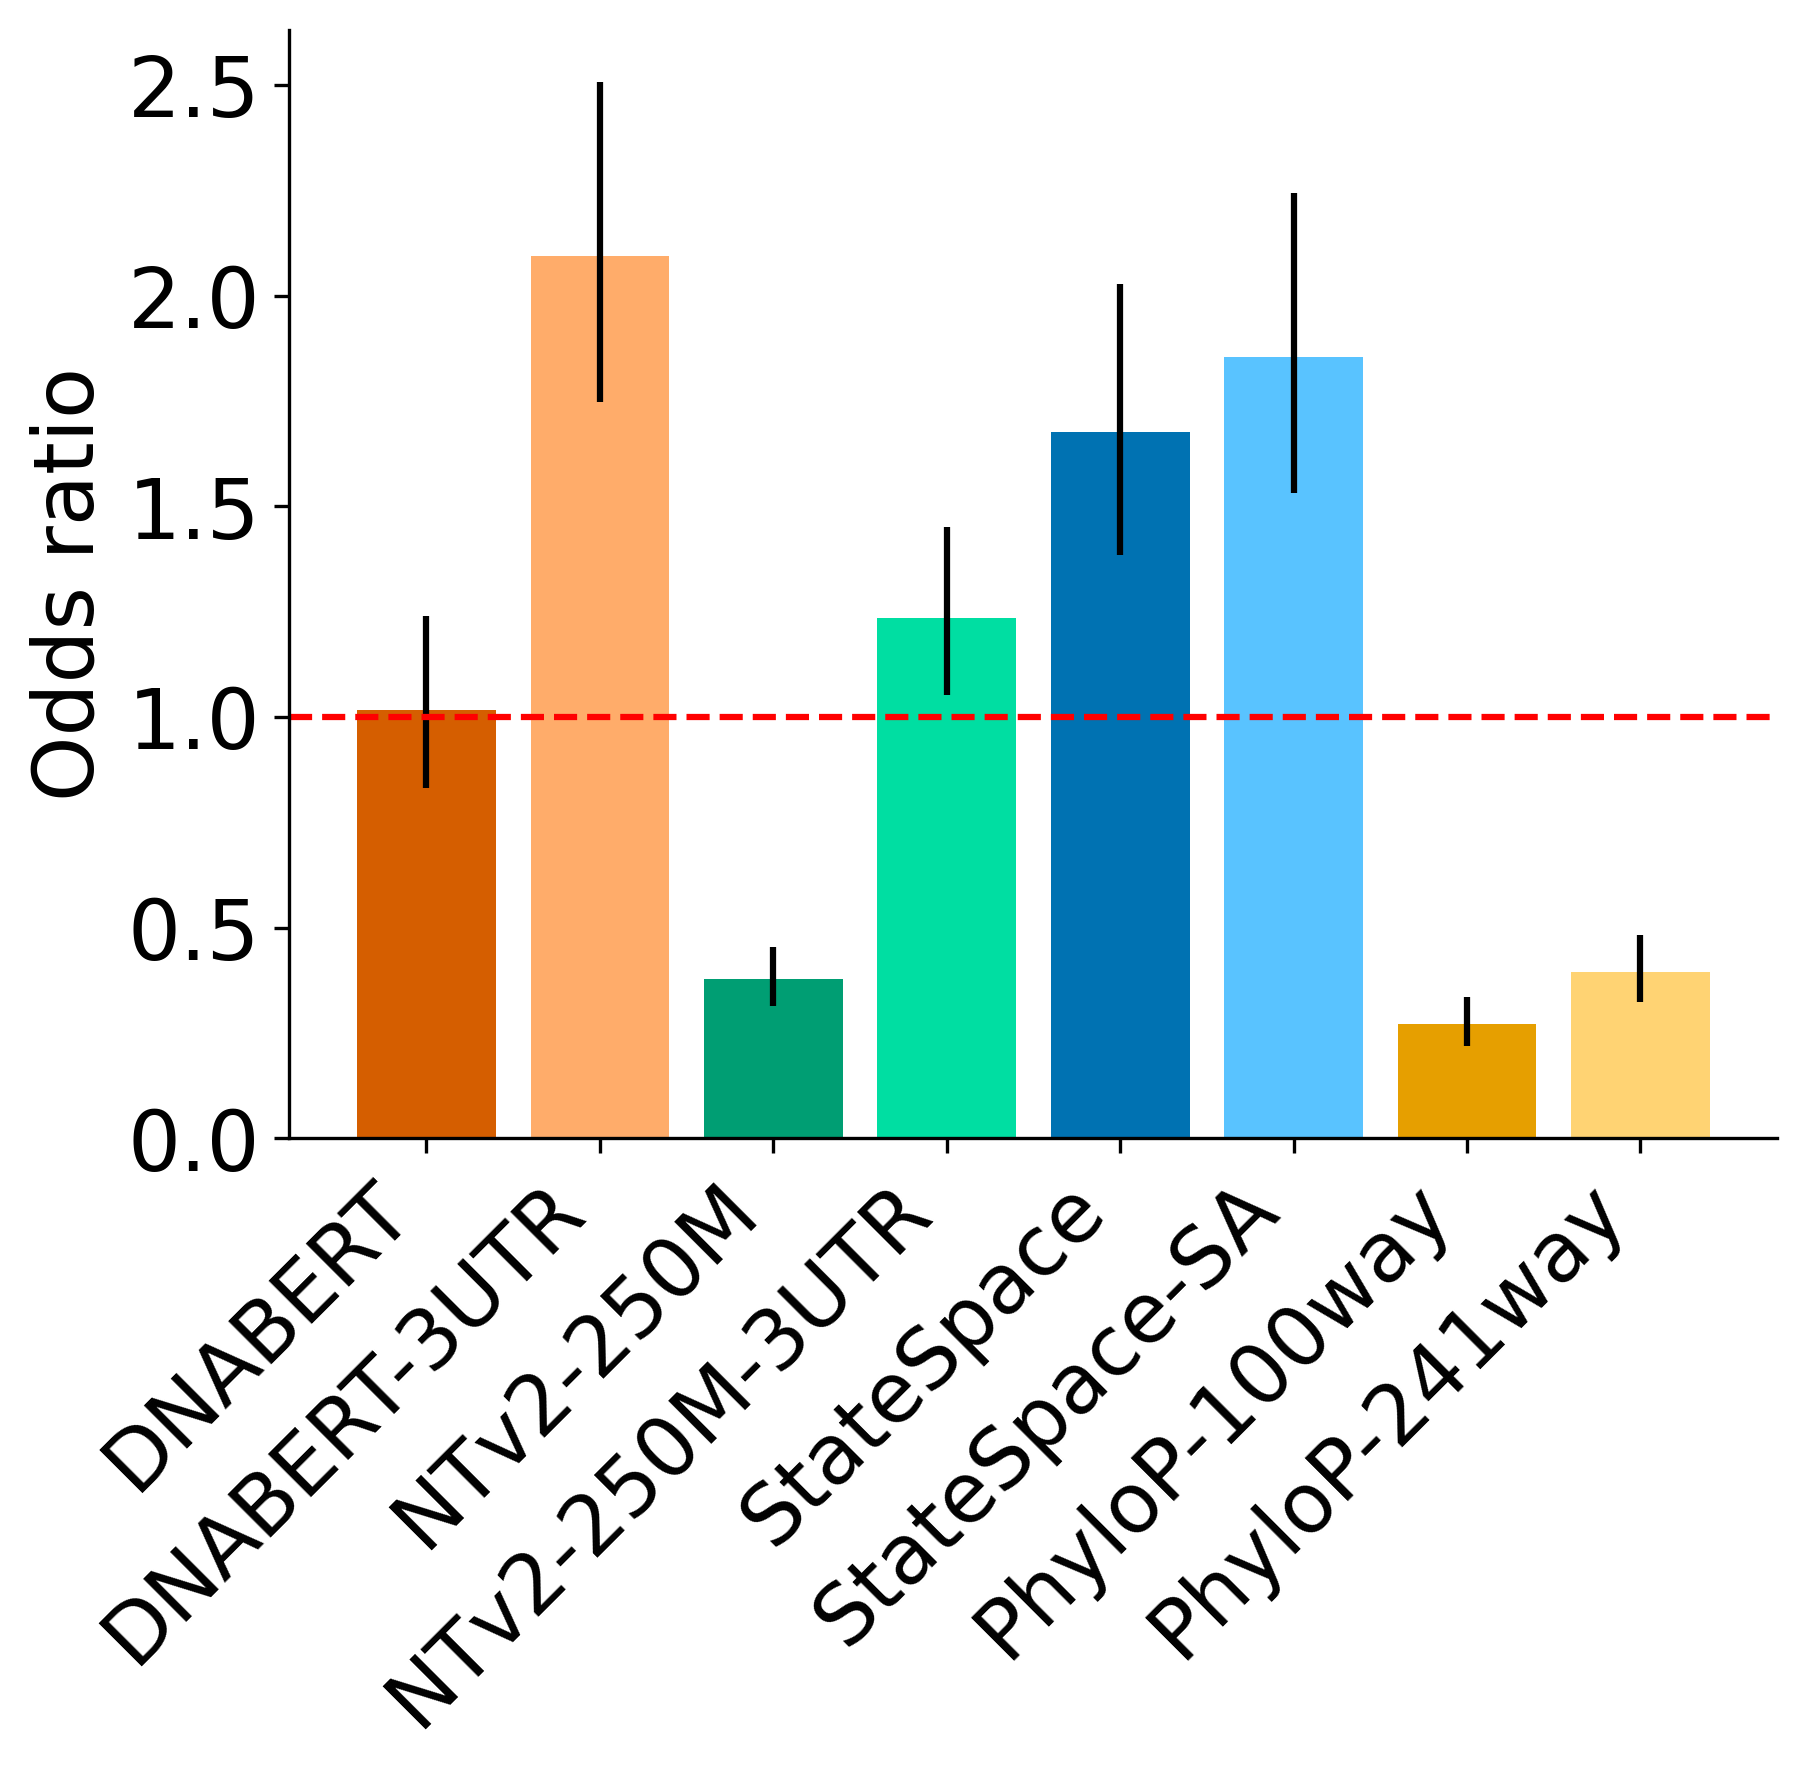

In [57]:
fig, ax = plt.subplots(dpi=300)


ax.bar(odds_ratios.index, odds_ratios.OR, 
       yerr=[odds_ratios.OR-odds_ratios.CI_95_low,odds_ratios.CI_95_high-odds_ratios.OR], 
       color=odds_ratios.index.map(model_colors))

plt.xticks(rotation=45, ha="right")
ax.set_ylabel('Odds ratio')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

if odds_ratios.OR.max()>50:
    ax.set_yscale('log')

ax.axhline(1,0,len(models),color='r', linestyle='--')

for model_idx, model in enumerate(odds_ratios.index):
    padj = odds_ratios.loc[model,'padj']
    if padj<1e-4:
        stars='****'
    elif padj<1e-3:
        stars='***'
    elif padj<1e-2:
        stars = '**'
    elif padj<5e-2:
        stars = '*'
    else:
        stars = 'ns'
    #if stars == 'ns':
        #ax.text(model_idx, odds_ratios.loc[model].OR+odds_ratios.OR.max()*0.03, f'{stars}',ha='center', va='center')


In [ ]:
fig, ax = plt.subplots(dpi=300)


motifs_df[(motifs_df.functional)&(motifs_df.valid_mobility)].drop_duplicates(subset=['seq_name','motif_start']).mobility.hist(ax=ax, density=True, bins=50)
ax.grid(True)
ax.set_axisbelow(True)
ax.set_ylabel('density')
ax.set_xlabel('mobility')
ax.set_xlim([0,299])

#if mobility_pct>0:
#    ylims = ax.get_ylim()
#    ax.vlines(x=mobility_thr,ymin=0,ymax=ylims[1], color='r', linestyle='--')
#    ax.set_ylim(ylims)
#    ax.text(x=mobility_thr, y=ylims[1]*0.9, s= f' {mobility_pct}th pct.',color='r')